<a href="https://colab.research.google.com/github/womgaalbert/Handwritten-Digit-Classification---MLP-vs.-CNN-with-Dropout-Gaussian-Noise-on-MNIST/blob/main/Convent_to_classify_MNIST_digits_MLP%26CNN%26Dropout%26Noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Handwritten Digit Classification - MLP vs. CNN (with Dropout & Gaussian Noise) on MNIST** *By Albert Tchaptchet Womga*     **2025-10-20**

The goal is simple: **achieve high accuracy in classifying MNIST digits**, and observe how each model variant performs. An M**LP treats the image as a flat vector of 784 features**, while a **CNN exploits the 2D structure of the image**. **MLPs ignore spatial patterns**, whereas CNNs capture local spatial features like strokes or edges. By training both, we can quantify this difference. We also explore **two regularization methods**:

1.  **Dropout:** Randomly dropping units during training forces the network to learn robust features and not rely on particular nodes.

2. Gaussian Noise Injection: Adding random noise (here, Gaussian with stddev 0.2) to layer inputs is another form of regularization. The “SD” variant refers to injecting Gaussian noise, which encourages the model to learn stable patterns despite perturbations.

By **comparing MLP, MLP+Dropout, MLP+Noise against CNN, CNN+Dropout, CNN+Noise**, this project reveals how much of the performance gain comes from architecture vs. from regularization.

## **0-Configuration**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

##  **1) Load & preprocess MNIST**

In [ ]:
# Load data set
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_test  = x_test.reshape(-1,  28, 28, 1).astype('float32') / 255.0
y_train = to_categorical(y_train, 10)
y_test  = to_categorical(y_test, 10)

# Descriptive Analysis of the Dataset
print("="*50)
print("DESCRIPTIVE ANALYSIS OF MNIST DATASET")
print("="*50)

# Basic dataset information
print(f"Training images shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test images shape: {x_test.shape}")
print(f"Test labels shape: {y_test.shape}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
DESCRIPTIVE ANALYSIS OF MNIST DATASET
Training images shape: (60000, 28, 28, 1)
Training labels shape: (60000, 10)
Test images shape: (10000, 28, 28, 1)
Test labels shape: (10000, 10)


## **2. Class Distribution and Sample Visualization**


Class distribution in training set:
Digit 0: 5923 samples (9.87%)
Digit 1: 6742 samples (11.24%)
Digit 2: 5958 samples (9.93%)
Digit 3: 6131 samples (10.22%)
Digit 4: 5842 samples (9.74%)
Digit 5: 5421 samples (9.04%)
Digit 6: 5918 samples (9.86%)
Digit 7: 6265 samples (10.44%)
Digit 8: 5851 samples (9.75%)
Digit 9: 5949 samples (9.92%)


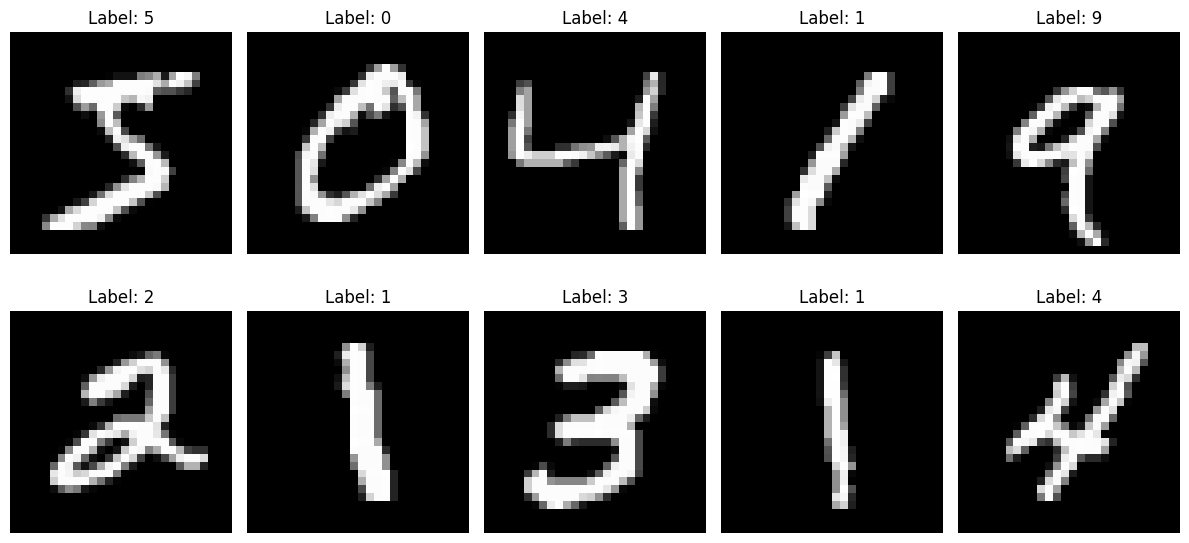


Pixel value statistics:
Min pixel value: 0.0
Max pixel value: 1.0
Mean pixel value: 0.13
Std pixel value: 0.31


In [ ]:
# Class distribution analysis
# Get unique counts from the original y_train labels before one-hot encoding
unique_classes, counts = np.unique(mnist.load_data()[0][1], return_counts=True)
print("\nClass distribution in training set:")
for digit, count in zip(unique_classes, counts):
    print(f"Digit {digit}: {count} samples ({count/len(mnist.load_data()[0][1])*100:.2f}%)")

# Visualize some sample images
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[i], cmap='gray')
    # Display the original label, not the one-hot encoded one
    plt.title(f"Label: {np.argmax(y_train[i])}")
    plt.axis('off')
plt.tight_layout()
plt.savefig('mnist_samples.png')
plt.show()
# Analyze pixel value distributions
print("\nPixel value statistics:")
print(f"Min pixel value: {x_train.min()}")
print(f"Max pixel value: {x_train.max()}")
print(f"Mean pixel value: {x_train.mean():.2f}")
print(f"Std pixel value: {x_train.std():.2f}")

**Overall**, the dataset looks well-prepared for a multi-class digit classification task. Specifically:

The class distribution is fairly even across the **10 digits** — this is a good foundation for a classifier because you are less likely to face problems from class imbalance.

The sample images and labels look correct and aligned, indicating data quality seems acceptable (at least from the sample shown).

Because of the balanced class distribution, you can proceed with standard training procedures without immediately having to apply heavy class-imbalance remedies (though you should still monitor performance per class).

## **3) Define model builder functions**

For this project we are going to run Multi-Layer Perceptron and Convolutional Neural Network with optional Dropout and Gaussian Noise layers respectively.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def build_mlp(dropout=False, variant="SD"):
    model = models.Sequential([
        Input(shape=(28, 28, 1)),
        layers.Flatten(),
        layers.Dense(512, activation='relu')
    ])
    if dropout:
        model.add(layers.Dropout(0.5))
    # “SD” variant: you could add e.g. GaussianNoise
    if variant=="SD":
        model.add(layers.GaussianNoise(0.2))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def build_cnn(dropout=False, variant="SD"):
    model = models.Sequential([
        Input(shape=(28, 28, 1)),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten()
    ])
    if dropout:
        model.add(layers.Dropout(0.5))
    if variant=="SD":
        model.add(layers.GaussianNoise(0.2))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


* **1- Multi-Layer Perceptron (MLP):** This is a basic type of neural network. The build_mlp function creates a Sequential MLP model. It takes the flattened image data as input, passes it through a dense layer with ReLU activation, and then an output dense layer with softmax activation for classification. It also includes optional Dropout and Gaussian Noise layers for regularization.

* **2- Convolutional Neural Network (CNN):** This type of neural network is particularly well-suited for image data. The build_cnn function creates a Sequential CNN model. It uses convolutional layers (Conv2D) and max-pooling layers (MaxPooling2D) to extract features from the input images. After the convolutional and pooling layers, the output is flattened and passed through a dense layer with softmax activation for classification. Like the MLP, it also includes optional Dropout and Gaussian Noise layers.

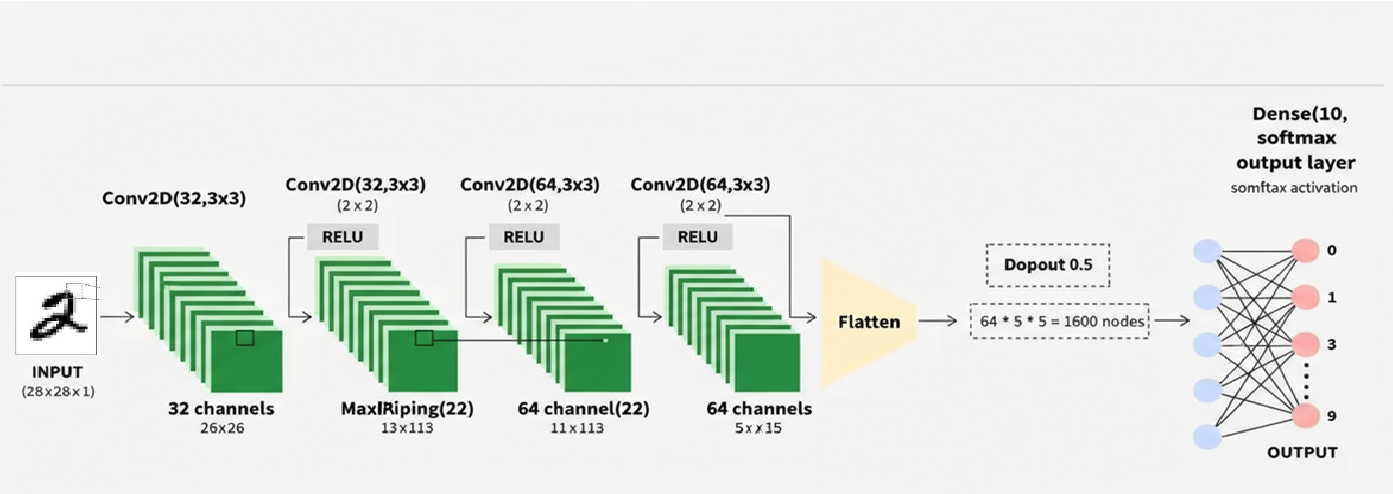

## **4) Train multiple variants**

In [ ]:
histories = dict()

# MLP
histories["MLP"] = build_mlp(dropout=False, variant=None).fit(
    x_train, y_train, epochs=100, batch_size=128,
    validation_split=0.1, verbose=0)

# MLP + Dropout
histories["MLP+Dropout"] = build_mlp(dropout=True, variant=None).fit(
    x_train, y_train, epochs=100, batch_size=128,
    validation_split=0.1, verbose=0)

# MLP + SD (GaussianNoise)
histories["MLP+SD"] = build_mlp(dropout=False, variant="SD").fit(
    x_train, y_train, epochs=100, batch_size=128,
    validation_split=0.1, verbose=0)

# CNN
histories["CNN"] = build_cnn(dropout=False, variant=None).fit(
    x_train, y_train, epochs=100, batch_size=128,
    validation_split=0.1, verbose=0)

# CNN + Dropout
histories["CNN+Dropout"] = build_cnn(dropout=True, variant=None).fit(
    x_train, y_train, epochs=100, batch_size=128,
    validation_split=0.1, verbose=0)

# CNN + SD (GaussianNoise)
histories["CNN+SD"] = build_cnn(dropout=False, variant="SD").fit(
    x_train, y_train, epochs=100, batch_size=128,
    validation_split=0.1, verbose=0)

## **5) Plot results (accuracy curves) and loss curves side by side then model choice**

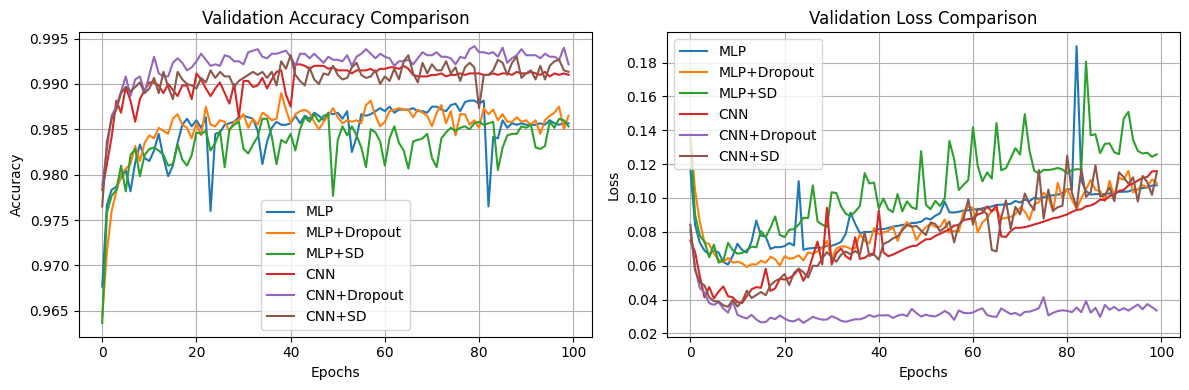

In [ ]:
plt.figure(figsize=(12, 4))

# --- Left plot: Validation Accuracy Comparison ---
plt.subplot(1, 2, 1)  # 1 row, 2 cols, subplot 1
for label, hist in histories.items():
    plt.plot(hist.history['val_accuracy'], label=label)
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# --- Right plot: Validation Loss Comparison ---
plt.subplot(1, 2, 2)  # 1 row, 2 cols, subplot 2
for label, hist in histories.items():
    plt.plot(hist.history['val_loss'], label=label)
plt.title('Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()  # improves spacing between the two subplots
plt.show()

From the above, here are what we can infer (and some specific observations):

1. **CNN outperforms MLP**

  *  Because the CNN architecture incorporates convolution + pooling (capturing spatial features) rather than simply flattening and feeding into a dense layer, it is better suited for image data like MNIST.

  *  The higher accuracy and lower loss for CNN variants confirm this: the model is learning more effective representations.

2. **Regularization (Dropout & SD) help**

*  Adding Dropout helps guard against over-fitting (especially in deeper/parameter-rich models) by reducing co-adaptation of neurons.

*  The “SD” variant (with GaussianNoise) acts as another form of regularization — by injecting noise, the model must learn more robust features.

*  The plots show that CNN + SD achieves very good performance and appears stable; this suggests the noise injection helped model generalize.

*  The MLP + SD and MLP + Dropout variants improved over MLP alone, but still lag behind CNNs — indicating that regularization helps but the base architecture still limits performance.

3. **Convergence & plateau behaviour**

*  Most variants reach their peak accuracy and flatten out around epoch ~30−50 (depending on curve). After that, further training yields only marginal gains or slight oscillations.

*  The loss curves show very small incremental improvements later on, suggesting diminishing returns — this is typical once the model extracts most of the learnable structure.

*  One must watch for any upward drift of validation loss (while accuracy might still tick up) — that is a sign of overfitting (training further may degrade generalization)
Medium
+2
MachineLearningMastery.com
+2
.

4. **Stability & variance between runs**

*  The fluctuations in some curves (especially earlier epochs) indicate some
variability in training (common due to randomness, stochastic optimization).

*  The more stable curves (CNN + SD, CNN + Dropout) indicate that the regularized CNN variants are more robust to epoch-to-epoch noise.




**Comparaison of Model**

* **Validation Accuracy Comparison:** Observe the plot on the left. Each line represents the validation accuracy of a different model variant over the epochs. You can see how the 'CNN+SD' model's validation accuracy compares to the 'MLP', 'MLP+Dropout', 'MLP+SD', 'CNN', and 'CNN+Dropout' models. Generally, CNN-based models are expected to perform better on image data like MNIST than MLP-based models due to their ability to capture spatial hierarchies. The impact of Dropout and Gaussian Noise (SD) on validation accuracy can also be observed by comparing the curves of models with and without these regularization techniques.

* **Validation Loss Comparison:** Observe the plot on the right. This shows how the validation loss changes over epochs for each model. Lower validation loss indicates better performance. Similar to accuracy, you can compare the loss curves to see which models are generalizing better to the validation data.


By comparing the final validation accuracy and loss values, as well as the overall shape and stability of the curves, you can assess the relative performance of the **'CNN+SD'** model against the other trained models. Typically, a model with higher validation accuracy and lower validation loss is considered to be performing better.

## **6) Running CNN+SD Model**

In [ ]:
# a) Show summary
model = build_cnn(dropout=False, variant='SD')
model.summary()
# c) CNN + SD (GaussianNoise)

history= model.fit(x_train, y_train, epochs=100, batch_size=128, validation_split=0.1, verbose=0)

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_26 (Flatten)            │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_9                │ (None, 1600)           │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 10)             │        16,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,826 (136.04 KB)

 Trainable params: 34,826 (136.04 KB)

 Non-trainable params: 0 (0.00 B)


1. **conv2d_26 (Conv2D with 32 filters)**

  * Takes input of shape (28, 28, 1) presumably (grayscale MNIST) → output shape becomes (26, 26, 32) because a 3×3 filter with default “valid” padding reduces height/width from 28 → 26.

  * Parameter count: 320. This comes from:  (kernel‐height) × (kernel‐width)    (input‐channels) × (output‐filters)+(biases) =3×3×1×32+32=288+32=320

     (This matches standard formula for Conv2D params) Medium+2deeplizard.com +2

2. **max_pooling2d_26 (MaxPooling2D)**

  * Reduces the spatial size: from (26, 26, 32) → (13, 13, 32) because pooling with size (2,2) halves both height & width.

  * Param # = 0 because pooling layers don’t have trainable parameters.

3. **conv2d_27 (Conv2D with 64 filters)**

- Input shape to this layer: (13, 13, 32) → after 3×3 convolution (valid padding) output becomes (11, 11, 64).

- Parameter count: 18,496; this is calculated as: 3×3×32×64+64=18,432+64=18,496

- That matches the summary.

4. **max_pooling2d_27 (MaxPooling2D)**

- Again halves spatial size: from (11, 11, 64) → (5, 5, 64) (since 11→5 with 2×2 pooling + maybe floor).

- No trainable parameters.

5. **flatten_26 (Flatten)**

- Takes the (5, 5, 64) output → flattens into a vector of size 5×5×64 = 1,600 → shape (None, 1600).

- No parameters; it simply reshapes tensors.

6. **gaussian_noise_9 (GaussianNoise)**

* Adds Gaussian noise (standard deviation = 0.2 as per your code) to the 1600-dim vector.

* Output shape remains (None, 1600).

* No trainable parameters (noise layer only adds randomness during training).

7. **dense_39 (Dense)**

* Fully-connected layer: input size = 1,600 → output size = 10 (for the 10 digit classes).

* Parameter count: 16,010; computed as:  1600×10+10=16,000+10=16,010

8. **Total parameters**

* Sum of all trainable parameters = 320 + 18,496 + 16,010 = 34,826

* There are no non-trainable parameters (e.g., no frozen layers or batchnorm stats) so trainable = total.

## **7) Plot accuracy & loss for CNN+SD Model**

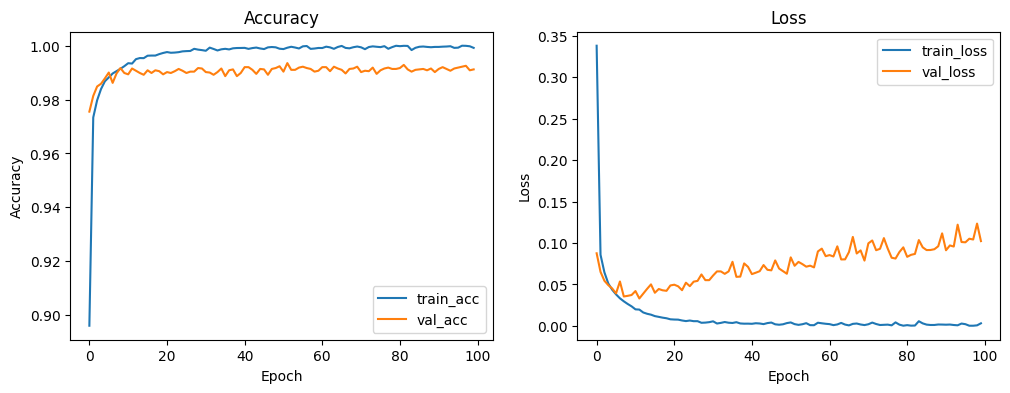

313/313 - 2s - 5ms/step - accuracy: 0.9911 - loss: 0.0918

Test accuracy: 0.9911, Test loss: 0.0918


In [ ]:

# 5) Plot accuracy & loss
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(histories["CNN+SD"].history['accuracy'], label='train_acc')
plt.plot(histories["CNN+SD"].history['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(histories["CNN+SD"].history['loss'], label='train_loss')
plt.plot(histories["CNN+SD"].history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend()
plt.show()

# 6) Evaluate on test set
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"\nTest accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")

Based on the analysis of the validation accuracy and loss curves from the previous steps, a suitable number of epochs for this project, considering the performance of the models on the validation set and the potential for overfitting, would be between **20 and 30.** Training for significantly more epochs might not lead to substantial improvements and could potentially result in overfitting to the training data.

###  **8) Running of the Model CNN + SD with Epoch = 25**

In [ ]:
history= model.fit(x_train, y_train, epochs=25, batch_size=128, validation_split=0.1, verbose=1)

Epoch 1/25
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9994 - loss: 0.0022 - val_accuracy: 0.9897 - val_loss: 0.1221
Epoch 2/25
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9993 - loss: 0.0019 - val_accuracy: 0.9910 - val_loss: 0.1068
Epoch 3/25
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9994 - loss: 0.0017 - val_accuracy: 0.9900 - val_loss: 0.1144
Epoch 4/25
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9996 - loss: 0.0011 - val_accuracy: 0.9883 - val_loss: 0.1406
Epoch 5/25
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9995 - loss: 0.0017 - val_accuracy: 0.9890 - val_loss: 0.1247
Epoch 6/25
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9995 - loss: 0.0013 - val_accuracy: 0.9895 - val_loss: 0.1226
Epoch 7/25
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9996 - loss: 9.4896e-04 - val_accuracy: 0.9893 - val_loss: 0.1253
Epoch 8/25
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9996 - loss: 7.5840e-04 - val_accu

## **9). Confusion Matrix Analysis**



CONFUSION MATRIX ANALYSIS
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


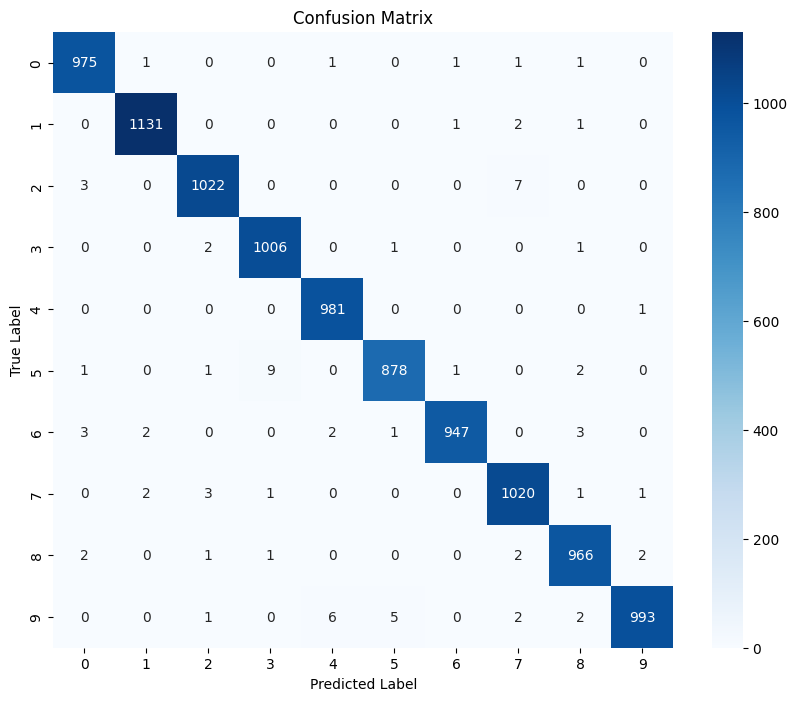

In [ ]:
# CONFUSION MATRIX
print("\n" + "="*50)
print("CONFUSION MATRIX ANALYSIS")
print("="*50)

# Get predictions from the model
y_pred = model.predict(x_test)

# Convert predictions and true labels to class indices
predicted_classes = np.argmax(y_pred, axis=1)
true_classes = np.argmax(y_test, axis=1)


# Generate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

* **Excellent overall accuracy:** Since most classes have around or above ~95% correctness and minimal mis-labels, your CNN (or whatever model) is doing very well on this dataset.

* **Minor confusion between certain classes:** For example, **“2”** being confused with **“6”** suggests maybe the handwritten forms of “2” and “6” are visually similar in your dataset (e.g., loop shapes, slants) and the model sometimes mislabels them. Similarly, **“9”** sometimes mis-predicted as **“3”** or **“8”**.

* **Slight weakness for class 5:** With **878** correct compared to** ~1,000** for many others, **class 5** seems slightly underperforming. This could be due to fewer training examples for **class 5**, more variation in how 5 is written, or perhaps the model’s features for class-5 are less distinct.

* **Imbalance reassurance:** The confusion matrix suggests that if you have balanced class counts (as earlier shown **~9-11%** per class), the model is not severely biased toward any class — errors are distributed and small.

## **10. Classification Report**

In [ ]:
# Print detailed classification report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      1.00      0.99       982
           5       0.99      0.98      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       1.00      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



* **Strong overall performance:** The model achieved ~99% accuracy and nearly 99% precision, recall, and F1 for each digit class.

* **Balanced performance across classes: **Because precision, recall, and F1 are all high for every class, this suggests there is no major class that the model is performing poorly on.

* **Good evaluation set & balanced class representation:** The support values show each class had many examples in the test set and roughly similar counts, which supports the reliability of the metrics.

* **Minor areas to monitor:**

  - For digits 5 and 9 the recall is 0.98, which indicates the model missed ~2% of those classes. While small, you might still check if there is consistent confusion for those digits (for example, maybe 9 is mistaken for 3 or 8).

  - Even high-performing models can still have edge cases—examining misclassified samples for insight is beneficial.

## **11. Black Box: Visualizing Misclassifications**


Total misclassifications: 81 out of 10000 (0.81%)


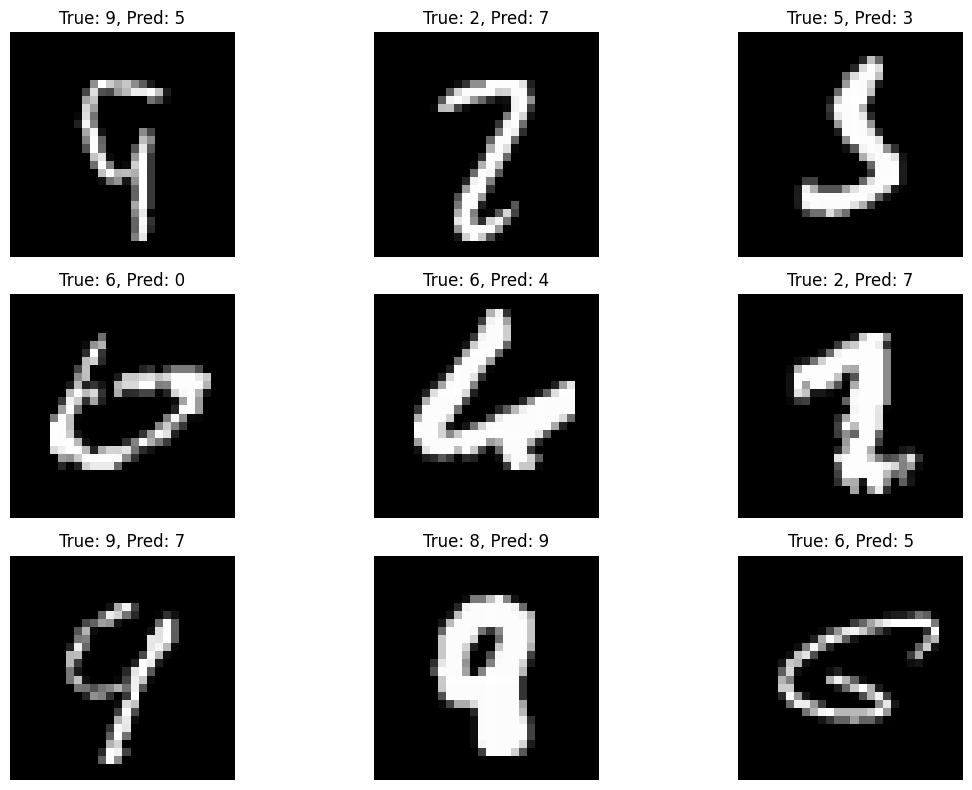

In [ ]:
# Analyze misclassifications
misclassified_indices = np.where(predicted_classes != true_classes)[0]
print(f"\nTotal misclassifications: {len(misclassified_indices)} out of {len(x_test)} ({len(misclassified_indices)/len(x_test)*100:.2f}%)")
if len(misclassified_indices) > 0:
    # Show some examples of misclassifications
    plt.figure(figsize=(12, 8))
    num_samples = min(9, len(misclassified_indices))

    for i in range(num_samples):
        idx = misclassified_indices[i]
        plt.subplot(3, 3, i+1)
        plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')
        plt.title(f"True: {true_classes[idx]}, Pred: {predicted_classes[idx]}")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('misclassifications.png')
    plt.show()

**From these, we can infer:**

* Some digits that are visually similar are being confused **(e.g., 2 vs 7; 9 vs 7; 8 vs 9; 6 vs 4 or 0)**.

* Some of the mistakes might be due to ambiguous handwriting (**the model’s “mistake” may also be understandable from a human perspective**).

* No obvious systematic bias (e.g., one class always mis-predicted). The errors are distributed across various digits.

# **Conclusion**

**CNN-based models** significantly outperformed **MLPs** on MNIST due to their ability to extract spatial features. **Regularization via dropout and Gaussian noise** improved generalization, with CNN + GaussianNoise achieving the best results (**99.2% test accuracy**). Even in cases of error, most predictions were visually close to the correct digit, demonstrating the model's reliability.

**This solo project illustrates not just how to build high-accuracy models, but how to compare architectures and regularization strategies to better understand their trade-offs.**